In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from qutip.ipynbtools import version_table

resol = 200
pi = np.pi
version_table()

Software,Version
QuTiP,5.1.1
Numpy,1.26.2
SciPy,1.11.3
matplotlib,3.7.3
Number of CPUs,11
BLAS Info,Generic
IPython,8.17.2
Python,"3.12.0 (v3.12.0:0fb18b02c8, Oct 2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]"
OS,posix [darwin]
Cython,3.0.11


<h1> Model </h1>

I consider the scattering of only one photon towards a 2-level atom. Also, I assume that several atoms might be in the waveguide (to play the role of a mirror for instance). I work in the subspace :

$$ \ket{1,0}, \ket{0,1} $$

And the Hamiltonian is given by: 

$$ H = \sum_k \omega_k a_k^{\dagger} a_k + \frac{1}{2} \sum_j \Omega_j (1 + \sigma_j^z) + \sum_{k,j}\left\{g(k,j) \sigma^+ a_k + \text{h.c} \right\} $$

with $g(k,j) = i g_0 \sqrt{\omega_k} e^{ikx_j}$

<h2> Parameters </h2>

In [314]:
#space discretization
L = 10*pi
N = 128 #number of sites on the lattice
position_tab = np.linspace(-L/2, L/2, N)
delta_x = position_tab[1] - position_tab[0]

#momentum space
n_modes = 128
k_tab = np.array([2*pi*n/L for n in range(-n_modes//2, n_modes//2)])
n_modes = len(k_tab) #adjust
omega_tab = np.abs(k_tab)

#atoms
n_A = 2
omega_A = 2
position_atom_tab = np.zeros(n_A)
omega_A_tab = np.zeros(n_A)

#atom at extermities of the cavity
position_atom_tab[0] = -L/10
position_atom_tab[1] = L/10
omega_A_tab[0] = omega_A
omega_A_tab[1] = omega_A

#initial wave packet
sigma = L/16
omega_0 = 2
x_0 = 0

#Jaynes cumming couplings
g_0 = 30
g_tab = np.zeros((n_modes, n_A), dtype=complex)
for i in range(n_modes):
    for j in range(n_A):
        g_tab[i, j] = 1j*g_0*np.sqrt(omega_tab[i])*np.exp(1j*k_tab[i]*position_atom_tab[j])

<h2> Hamiltonian </h2>

In [315]:
dim_subspace = n_modes + n_A
H_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)

##diagonal elements
for i in range(n_modes):
    H_matrix[i, i] = omega_tab[i]
for i in range(n_A):
    H_matrix[n_modes+i, n_modes+i] = omega_A_tab[i]

##of diagonal elements
for i in range(n_modes):
    for j in range(n_A):
        H_matrix[i, n_modes+j] = g_tab[i, j]
        H_matrix[n_modes+j, i] = np.conjugate(H_matrix[i, n_modes+j])

H = qt.Qobj(H_matrix)
print("Hermicity of the Hamiltonian: ", H.isherm)

Hermicity of the Hamiltonian:  True


<h2> Photonic occupation operators </h2>

In [316]:
occupation_nb_photon_momentum_list = []
occupation_nb_photon_position_list = []

#occupation number operators in momentum space
for i in range(n_modes):
    occupation_nb_photon_momentum_list.append(qt.basis(dim_subspace, i) * qt.basis(dim_subspace, i).dag())

#Fourier transform to get the occupation number operators in position space
for x in range(N):
    position = position_tab[x]
    position_state = 0
    for i in range(n_modes):
        position_state += 1/np.sqrt(N) * np.exp(-1j * k_tab[i] * position) * qt.basis(dim_subspace, i)
    
    occupation_nb_photon_position_list.append(position_state * position_state.dag())

<h1> Initial state </h1>

In [317]:
k_0 = omega_0
k_bar = k_tab[np.argmin(np.abs(k_tab - k_0))]
x_bar = position_tab[np.argmin(np.abs(position_tab - x_0))]

init_state = 0
for i in range(n_modes):
    init_state += np.exp(-0.5*sigma**2*(k_tab[i] - k_bar)**2 -1j * k_tab[i] * x_bar) * qt.basis(dim_subspace, i)
init_state = init_state.unit()


<h2> Plot initial wave packet </h2>

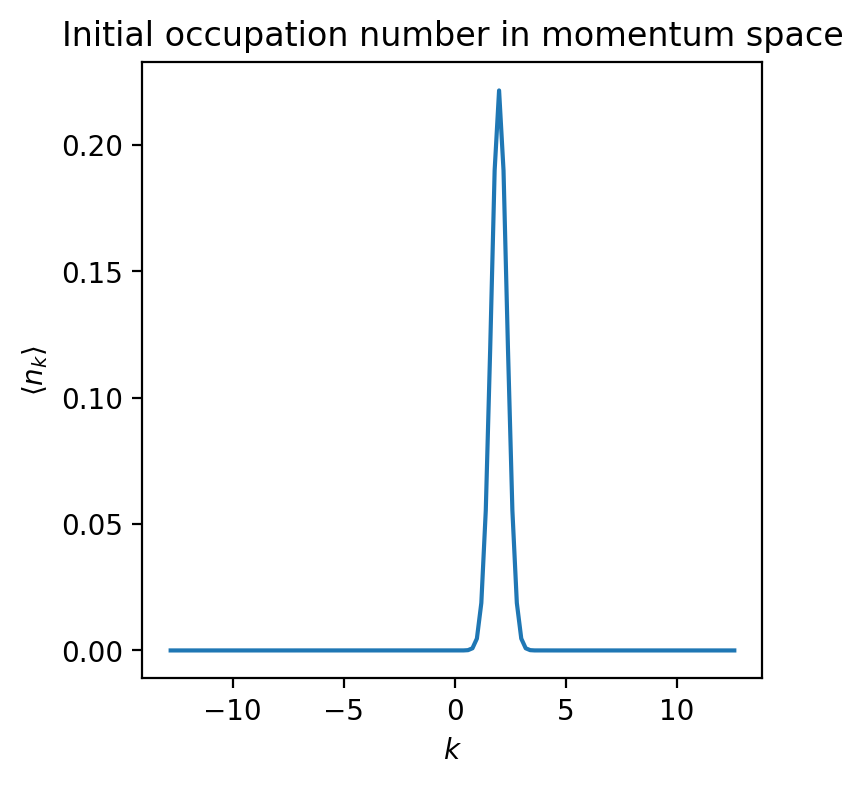

In [318]:
coef_list = np.zeros(n_modes)
for i in range(n_modes):
    coef_list[i] = qt.expect(occupation_nb_photon_momentum_list[i], init_state)

fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=resol)
ax.plot(k_tab, coef_list)
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$\langle n_k \rangle$")
ax.set_title("Initial occupation number in momentum space")
plt.show()

<h1> Time evolution </h1>

In [319]:
T = L/2
dt = 0.5
nb_pts = 3*int(T/dt)
times = np.linspace(0, T, nb_pts)
result = qt.sesolve(H, init_state, times, e_ops=occupation_nb_photon_momentum_list + occupation_nb_photon_position_list)

<h2> Visualize the results

In [320]:
result_momentum_space = result.expect[:n_modes]
result_position_space = result.expect[n_modes:]

In position space

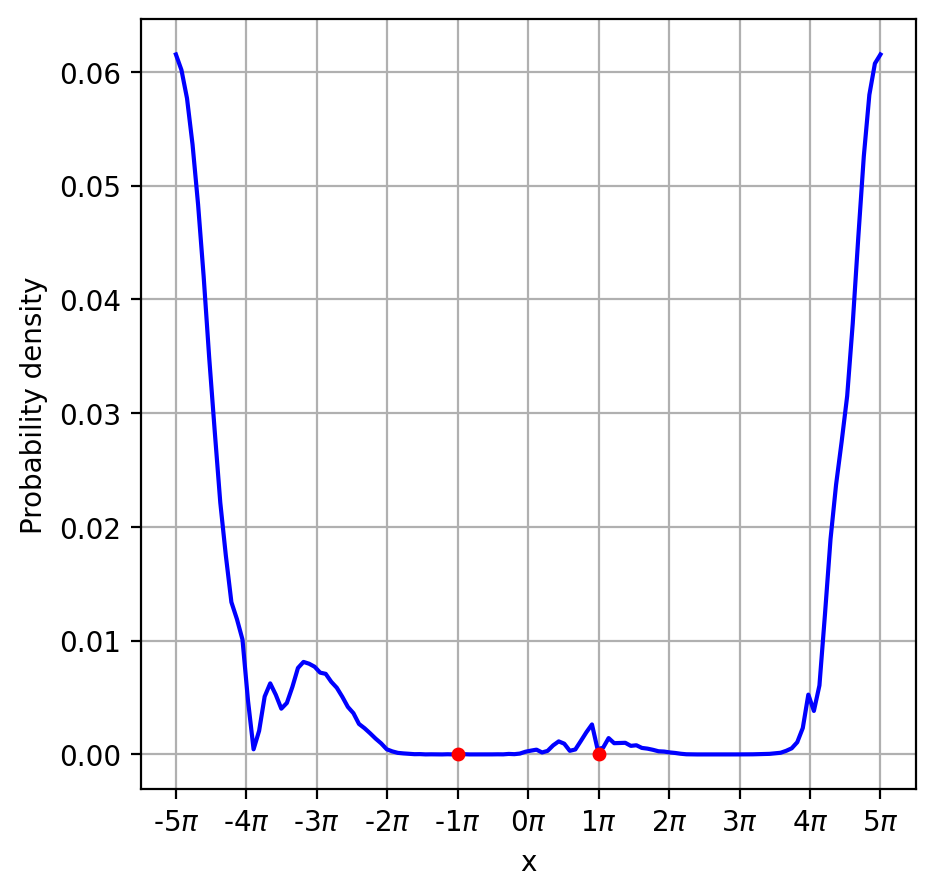

In [321]:
t_index = -1
mean_occupation_list = []
for i in range(N):
    mean_occupation_list.append(result_position_space[i][t_index])

fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=resol)

#evolution of the probability density in position space
ax.plot(position_tab, mean_occupation_list, color='blue', markersize=4)

#show the atoms on the x axis
ax.plot(position_atom_tab, np.zeros_like(position_atom_tab), 'o', color='red', markersize=4)

#show proper labels
ax.set_xticks([i*pi for i in range(-1*int(L//(2*pi)), int(L//(2*pi)+1))])
ax.set_xticklabels([str(i)+'$\\pi$' for i in range(-1*int(L//(2*pi)),int(L//(2*pi)+1))])

ax.set_xlabel('x')
ax.set_ylabel('Probability density')

ax.grid()


plt.show()

Create an animation

MovieWriter ffmpeg unavailable; using Pillow instead.


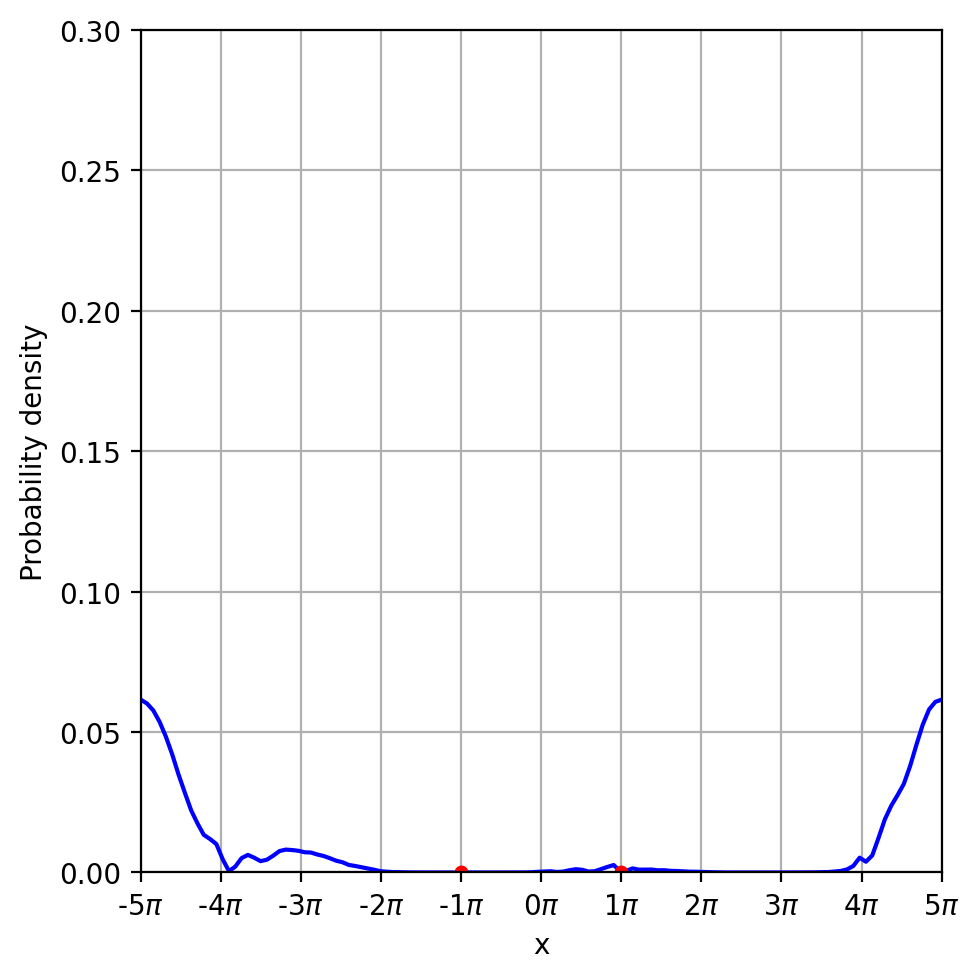

In [322]:
#animating the results from t=0 to t=99
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=resol)

line, = ax.plot([], [], color='blue', markersize=4)
ax.plot(position_atom_tab, np.zeros_like(position_atom_tab), 'o', color='red', markersize=4)
ax.set_xticks([i*pi for i in range(-1*int(L//(2*pi)), int(L//(2*pi)+1))])
ax.set_xticklabels([str(i)+'$\\pi$' for i in range(-1*int(L//(2*pi)),int(L//(2*pi)+1))])
ax.set_xlabel('x')
ax.set_ylabel('Probability density')
ax.set_ylim(0, 0.3)
ax.grid()

def init():
    line.set_data([], [])
    return line,

def update(t):
    mean_occupation_list = []
    for i in range(N):
        mean_occupation_list.append(result_position_space[i][t])

    line.set_data(position_tab, mean_occupation_list)
    return line,

ani = FuncAnimation(fig, update, frames=nb_pts, init_func=init, blit=True)
ani.save('test.gif', writer='ffmpeg', fps=24)

fig.tight_layout()
plt.show()

Now, let me compute the probability to find the photon in the cavity against time

In [323]:
cavity_start = position_atom_tab[0]
cavity_end = position_atom_tab[1]

x_1 = position_tab[np.argmin(np.abs(position_tab - cavity_start))]
x_2 = position_tab[np.argmin(np.abs(position_tab - cavity_end))]
index_x1 = np.argmin(np.abs(position_tab - cavity_start))
index_x2 = np.argmin(np.abs(position_tab - cavity_end))

occupation_cavity = np.zeros(nb_pts)
for i in range(nb_pts):
    current_occupation = 0
    for j in range(index_x1, index_x2+1):
        current_occupation += result_position_space[j][i]
    occupation_cavity[i] = current_occupation

plot the result

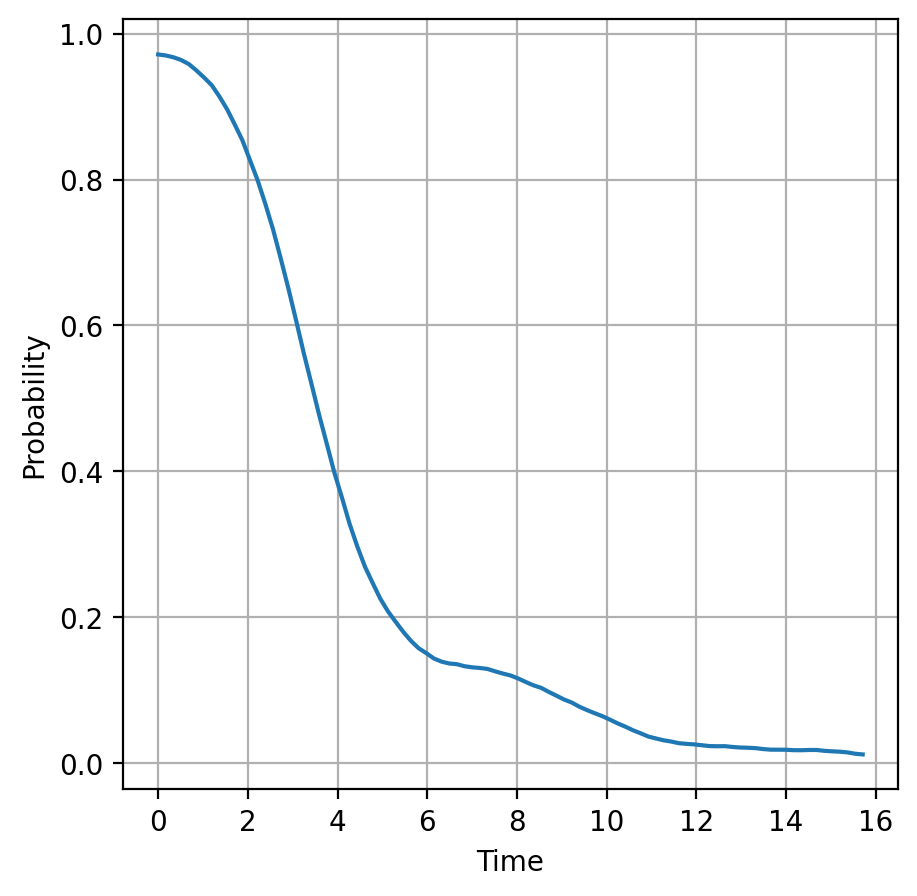

In [324]:
fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=resol)
ax.plot(times, occupation_cavity)
ax.set_xlabel('Time')
ax.set_ylabel('Probability')
ax.grid()

plt.show()
